# Image Classification: How to run inference on the endpoint you have created?

### Download example images. 

In [1]:
import boto3
from IPython.core.display import HTML

In [2]:
# to get the execution role programatically

# import sagemaker

# sagemaker_session = sagemaker.Session()
# role = sagemaker.get_execution_role()
# role

In [3]:
# Define constants / names
s3_bucket = "pepsico-potato-chip-dataset"
key_prefix = "Test"

# I deleted this endpoint, but its configuration file was still hanging around or something
# So when I re-created an endpoint from the same training job, using the default endpoint
# name, I got an error
# endpoint_name = 'jumpstart-ftc-tf-ic-imagenet-inception-v3-classificati'

endpoint_name = 'jumpstart-ftc-inception-v3-chips'

In [4]:
region = boto3.Session().region_name
s3 = boto3.client("s3")

In [5]:
# get a list of files in our Bucket's sub-folder

response = s3.list_objects_v2(
    Bucket=s3_bucket,
    Prefix=f"{key_prefix}/Defective"
)

defective_objects = [x['Key'] for x in response['Contents']]

response = s3.list_objects_v2(
    Bucket=s3_bucket,
    Prefix=f"{key_prefix}/Non-Defective"
)
non_defective_objects = [x['Key'] for x in response['Contents']]

In [6]:
# a peek at one of the file lists
non_defective_objects[:5]

['Test/Non-Defective/IMG_20210318_231142.jpg',
 'Test/Non-Defective/IMG_20210318_231155.jpg',
 'Test/Non-Defective/IMG_20210318_231229.jpg',
 'Test/Non-Defective/IMG_20210318_231234.jpg',
 'Test/Non-Defective/IMG_20210318_231242.jpg']

## Examine a few images at random

In [7]:
import random

In [8]:
def_obj_ex = random.choice(defective_objects)
non_obj_ex = random.choice(non_defective_objects)

# get the filename from the object string
def_ex = def_obj_ex.split('/')[-1]
non_def_ex = non_obj_ex.split('/')[-1]

s3.download_file(
    Bucket="pepsico-potato-chip-dataset",
    Key=def_obj_ex,
    Filename=def_ex
)

s3.download_file(
    Bucket="pepsico-potato-chip-dataset",
    Key=non_obj_ex,
    Filename=non_def_ex
)

In [9]:
# Open the downloaded images and load in memory.
images = {}
with open(def_ex, 'rb') as file: images[def_ex] = file.read()
with open(non_def_ex, 'rb') as file: images[non_def_ex] = file.read()

# display them using HTML
HTML(f'<table><tr><td> <img src="{def_ex}" alt="def" style="height: 250px;"/> <figcaption>def.jpg</figcaption>'
     f'</td><td> <img src="{non_def_ex}" alt="non-def" style="height: 250px;"/> <figcaption>non_def.jpg</figcaption>'
     '</td></tr></table>')

def.jpg,non_def.jpg


### Query endpoint that you have created with the opened images and parse predictions

Note: Backend scripts and the notebooks have been updated in Jan '22. This notebook will not work with the previously 
launched endpoints. If experiencing an error, please launch the endpoint again. 

In [10]:
import json

def query_endpoint(img):
    client = boto3.client('runtime.sagemaker')
    response = client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='application/x-image',
        Body=img,
        Accept='application/json;verbose'
    )
    return response
    

def parse_prediction(query_response):
    model_predictions = json.loads(query_response['Body'].read())
    predicted_label = model_predictions['predicted_label']
    labels = model_predictions['labels']
    probabilities = model_predictions['probabilities']
    return predicted_label, probabilities, labels 

for filename, img in images.items():
    query_response = query_endpoint(img)
    predicted_label, probabilities, labels = parse_prediction(query_response)
    display(HTML(f'<img src={filename} alt={filename} align="left" style="width: 250px;"/>' 
                 f'<figcaption>Predicted Label is : {predicted_label}</figcaption>'))

In [11]:
probabilities

[0.00013891388717546943, 0.9998610861128245]

In [12]:
# Clean up: remove the files
import os

os.remove(def_ex)

# Loop through predictions

In [13]:
def fetch_and_predict(obj):
    file_name = obj.split('/')[-1]
    s3.download_file(
        Bucket="pepsico-potato-chip-dataset",
        Key=obj,
        Filename=file_name
    )
    with open(file_name, 'rb') as file: img = file.read()
    query_response = query_endpoint(img)
    predicted_label, probabilities, labels = parse_prediction(query_response)
    os.remove(file_name)
    return predicted_label, probabilities

In [14]:
def loop_thru_obj_list(obj_list):
    pred_dict = {}
    problem_files = {}
    for i, obj in enumerate(obj_list):
        try:
            file_name = obj.split('/')[-1]
            pred, probas = fetch_and_predict(obj)
            pred_dict[file_name] = [pred, probas]
        except Exception as e:
            problem_files[file_name] = e
    
    return pred_dict, problem_files

In [15]:
def_preds, def_problem_files = loop_thru_obj_list(defective_objects)
non_def_preds, nondef_problem_files = loop_thru_obj_list(non_defective_objects)

In [16]:
len(def_preds), len(non_def_preds), len(def_problem_files), len(nondef_problem_files)

(92, 100, 1, 1)

In [17]:
# peek at a few of the predictions
list(def_preds.values())[:5]

[['Non-Defective', [0.23878851089295614, 0.761211489107044]],
 ['Defective', [0.7910151357410026, 0.2089848642589975]],
 ['Non-Defective', [0.05198489549567822, 0.9480151045043219]],
 ['Defective', [0.931124458536519, 0.06887554146348095]],
 ['Non-Defective', [0.098764932790887, 0.901235067209113]]]

In [18]:
# evaluate
d_correct = len(list(filter(lambda x: x[0] == 'Defective', list(def_preds.values()))))
d_total = len(def_preds)

nd_correct = len(list(filter(lambda x: x[0] == 'Non-Defective', list(non_def_preds.values()))))
nd_total = len(non_def_preds)

# overall 
accuracy = (d_correct + nd_correct) / (d_total + nd_total)
accuracy

0.8645833333333334

In [19]:
# Categorical accuracy
d_acc = d_correct / d_total
nd_acc = nd_correct / nd_total
print(d_acc)
print(nd_acc)

0.717391304347826
1.0


In [20]:
import matplotlib.pyplot as plt

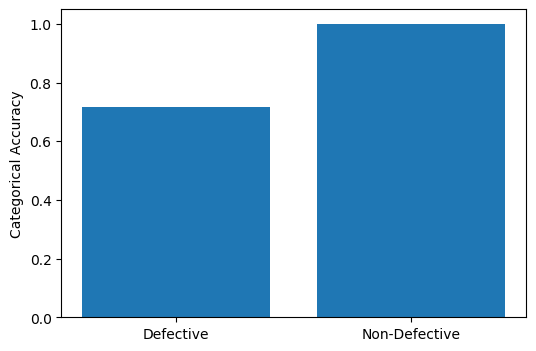

In [21]:
plt.figure(figsize=(6,4))
plt.bar([0, 1], [d_acc, nd_acc])
plt.xticks([0,1], labels=["Defective", "Non-Defective"])
plt.ylabel("Categorical Accuracy")
plt.show()